## Final Project
### 20182650 Jang Jaehoon


## Load Data using github

In [1]:
!git clone https://github.com/leehahoon/question_quality_assessment.git git_dir

Cloning into 'git_dir'...
remote: Enumerating objects: 983, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 983 (delta 7), reused 26 (delta 5), pack-reused 953
Receiving objects: 100% (983/983), 51.28 MiB | 25.04 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
import pandas as pd
data = pd.read_csv('git_dir/data/train_data/train_task_3_4.csv')
data.head()

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2
3,490,1653,997498,1,4,4
4,298,3912,578636,1,3,3


### Get correct rate inverse score

In [3]:
result_df = pd.DataFrame()
result_df['Correct_Rate'] = data.groupby('QuestionId').agg(['mean'])['IsCorrect']
result_df['Correct_Rate_Inverse'] = 1-result_df['Correct_Rate']


### Get subject score

In [4]:
import ast

question_metadata = pd.read_csv('git_dir/data/metadata/question_metadata_task_3_4.csv')
subj_metadata = pd.read_csv('git_dir/data/metadata/subject_metadata.csv')

question_data = question_metadata.sort_values('QuestionId')
question_data['SubjectList'] = question_data['SubjectId'].apply(lambda x: ast.literal_eval(x))
question_data['SubjectLen'] = question_data['SubjectList'].apply(len)
question_data.set_index('QuestionId', inplace=True)
question_data.head()
# get SubjectList's length

result_df['Subject_Score'] = 10-question_data['SubjectLen']
result_df

# The longer the length, the more diverse the problem area.
# so, 10 - (SubjectLen)


,Correct_Rate,Correct_Rate_Inverse,Subject_Score
QuestionId,,,
0,0.443457,0.556543,6
1,0.571429,0.428571,6
2,0.385214,0.614786,4
3,0.808757,0.191243,6
4,0.401408,0.598592,6
...,...,...,...
943,0.566528,0.433472,6
944,0.142857,0.857143,6
945,0.422336,0.577664,6


### Get answer value entropy

In [5]:
import pandas as pd
import scipy as sp
from scipy.stats import multinomial
import os
import pandas as pd
import numpy as np
import argparse

result_df['AnswerValue_Entropy'] = data.groupby('QuestionId')['AnswerValue'].agg(lambda x:multinomial.entropy(1,x.value_counts(normalize=True)).mean())
# reference : starter_kit - sample_model_entropy
# A smaller value means the answer to the question is easier to predict.

### Get question correct entropy

In [6]:
result_df['IsCorrect_Entropy'] = data.groupby('QuestionId')['IsCorrect'].agg(lambda x:multinomial.entropy(1,x.value_counts(normalize=True)).mean())
# Calculates the entropy of the polynomial distribution of the IsCorrect column for each question
# A smaller value means that the correct answer for that question is easier to predict.

### Get characters in images

In [7]:
# Reference -> image2text.ipynb
data = pd.read_csv('git_dir/data/metadata/imagesText.csv')
data.set_index('QuestionId', inplace=True)
result_df['QuestionTextLength'] = data['QuestionTextLength']
result_df.head()


,Correct_Rate,Correct_Rate_Inverse,Subject_Score,AnswerValue_Entropy,IsCorrect_Entropy,QuestionTextLength
QuestionId,,,,,,
0,0.443457,0.556543,6,1.194456,0.686739,141
1,0.571429,0.428571,6,0.876006,0.682908,46
2,0.385214,0.614786,4,1.331663,0.666559,105
3,0.808757,0.191243,6,0.695423,0.488020,53
4,0.401408,0.598592,6,1.324321,0.673579,125


## Rank features

In [8]:
rank_df = pd.DataFrame()

rank_df['Correct_Rate_Inverse'] = result_df['Correct_Rate_Inverse'].rank(method='first', ascending=False).astype('int16')
rank_df['CR_inverse+SS'] = (result_df['Correct_Rate_Inverse'] + result_df['Subject_Score']).rank(method='first', ascending=False).astype('int16')
rank_df['QuestionTextLength'] = result_df['QuestionTextLength'].rank(method='first', ascending=False).astype('int16')
rank_df['QuestionTextLength_Inverse'] = result_df['QuestionTextLength'].rank(method='first', ascending=True).astype('int16')
rank_df['CR_inverse+QuestionTextLength'] = (result_df['Correct_Rate_Inverse'] + result_df['QuestionTextLength']).rank(method='first', ascending=False).astype('int16')
rank_df['CR_inverse+SS+QuestionTextLength'] = (result_df['Correct_Rate_Inverse'] + result_df['QuestionTextLength'] + result_df['Subject_Score']).rank(method='first', ascending=False).astype('int16')

rank_df.head()

,Correct_Rate_Inverse,CR_inverse+SS,QuestionTextLength,QuestionTextLength_Inverse,CR_inverse+QuestionTextLength,CR_inverse+SS+QuestionTextLength
QuestionId,,,,,,
0,355,345,322,624,322,322
1,619,608,847,98,848,848
2,228,948,494,443,497,512
3,922,908,818,130,819,819
4,273,264,387,557,389,389


In [9]:
rank_df['Correct_Rate_Inverse'].to_csv('Correct_Rate_Inverse.csv', header=True, index_label='QuestionId')
rank_df['CR_inverse+SS'].to_csv('CR_inverse+SS.csv', header=True, index_label='QuestionId')
rank_df['QuestionTextLength'].to_csv('QuestionTextLength.csv', header=True, index_label='QuestionId')
rank_df['QuestionTextLength_Inverse'].to_csv('QuestionTextLength_Inverse.csv', header=True, index_label='QuestionId')
rank_df['CR_inverse+QuestionTextLength'].to_csv('CR_inverse+QuestionTextLength.csv', header=True, index_label='QuestionId')
rank_df['CR_inverse+SS+QuestionTextLength'].to_csv('CR_inverse+SS+QuestionTextLength.csv', header=True, index_label='QuestionId')



## Evaluate (Public)

In [10]:
# load evaluators' score on "validation" set
eval_validation = pd.read_csv('git_dir/data/test_data/quality_response_remapped_public.csv')
print(len(eval_validation))
eval_validation

# take the average of 5 evaulators` scores
eval_validation['score'] = eval_validation.filter(regex='^T', axis = 1).mean(axis=1)


25


In [11]:
# decide preference
import numpy as np
def calc_preference(scores):
    preference = np.ones(len(scores), dtype=int)

    idx_two = scores > 1.5
    preference[idx_two] = 2

    return list(preference)

eval_validation['preference'] = calc_preference(eval_validation['score'])
# eval_dev[]
# eval_dev['score']

In [12]:
def evaluate(truth, submission):
    # extract ranking
    left = list(truth.left)
    right = list(truth.right)
#     if len(left) != len(right):
#     message = 'left and right lengths are not the same'
#     sys.exit(message)

    submission_left = []
    submission_right = []
    submission_preference = []
    for idx in range(len(left)):
        submission_left.append(left[idx])
        submission_right.append(right[idx])
        ranking_left = submission[submission.QuestionId==left[idx]].ranking.values[0]
        ranking_right = submission[submission.QuestionId==right[idx]].ranking.values[0]
        preference = 1 if ranking_left < ranking_right else 2
        submission_preference.append(preference)
    #print(submission_preference)
    return submission_preference

In [13]:
csv_filelist = ['Correct_Rate_Inverse', 'CR_inverse+SS', 'QuestionTextLength', 'QuestionTextLength_Inverse', 'CR_inverse+QuestionTextLength', \
                'CR_inverse+SS+QuestionTextLength']
templates = []
for csv_file in csv_filelist:
  templates.append(pd.read_csv(csv_file+'.csv'))

for template in templates:
  template.columns = ['QuestionId', 'ranking']

print(templates[0])


     QuestionId  ranking
0             0      355
1             1      619
2             2      228
3             3      922
4             4      273
..          ...      ...
943         943      613
944         944        1
945         945      310
946         946      395
947         947      710

[948 rows x 2 columns]


In [14]:
eval_pub_result = {}
for idx in range(len(templates)):
  eval_pub_result[csv_filelist[idx]] = evaluate(eval_validation, templates[idx])

print(eval_pub_result)


{'Correct_Rate_Inverse': [2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1], 'CR_inverse+SS': [2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1], 'QuestionTextLength': [2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1], 'QuestionTextLength_Inverse': [1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2], 'CR_inverse+QuestionTextLength': [2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1], 'CR_inverse+SS+QuestionTextLength': [2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 1]}


In [15]:
def getCompareDF(eval_validation, estimate_df):
  df = pd.DataFrame()
  df['truth'] = eval_validation['preference']
  df['estimate'] = estimate_df
  df['evaluate'] = df['truth'] == df['estimate']
  df['score'] = df['evaluate'].apply(lambda x: 1 if x else 0)
  total_score = df['score'].sum()
  total_percent = total_score/df['score'].count()
  return (total_score, total_percent)

for key, value in eval_pub_result.items():
  score, percent = getCompareDF(eval_validation, value)
  print(f'{key}: {score}, {percent}')


Correct_Rate_Inverse: 19, 0.76
CR_inverse+SS: 20, 0.8
QuestionTextLength: 14, 0.56
QuestionTextLength_Inverse: 11, 0.44
CR_inverse+QuestionTextLength: 14, 0.56
CR_inverse+SS+QuestionTextLength: 14, 0.56


## Evaluate (Private)

In [16]:
eval_test = pd.read_csv('git_dir/data/test_data/quality_response_remapped_private.csv')
eval_test['score'] = eval_test.filter(regex='^T', axis = 1).mean(axis=1)
eval_test['preference'] = calc_preference(eval_test['score'])

eval_priv_result = {}
for idx in range(len(templates)):
  eval_priv_result[csv_filelist[idx]] = evaluate(eval_test, templates[idx])

for key, value in eval_priv_result.items():
  score, percent = getCompareDF(eval_test, value)
  print(f'{key}: {score}, {percent}')



Correct_Rate_Inverse: 17, 0.68
CR_inverse+SS: 17, 0.68
QuestionTextLength: 15, 0.6
QuestionTextLength_Inverse: 10, 0.4
CR_inverse+QuestionTextLength: 15, 0.6
CR_inverse+SS+QuestionTextLength: 15, 0.6


## Select best subset

In [17]:
import itertools

# Calculate the combination of all columns
combinations = []
column_combinations = []
num_columns = len(result_df.columns)

for r in range(1, num_columns+1):
    for cols in itertools.combinations(result_df.columns, r):
        combination_sum = result_df[list(cols)].sum(axis=1)
        combinations.append(combination_sum)
        column_combinations.append(list(cols))  # Save column name combinations

subset_df = pd.concat(combinations, axis=1)
subset_df.columns = ['Combination_{}'.format(i) for i in range(len(combinations))]

print(column_combinations[62])

subset_df.head()

['Correct_Rate', 'Correct_Rate_Inverse', 'Subject_Score', 'AnswerValue_Entropy', 'IsCorrect_Entropy', 'QuestionTextLength']


,Combination_0,Combination_1,Combination_2,Combination_3,Combination_4,Combination_5,Combination_6,Combination_7,Combination_8,Combination_9,...,Combination_53,Combination_54,Combination_55,Combination_56,Combination_57,Combination_58,Combination_59,Combination_60,Combination_61,Combination_62
QuestionId,,,,,,,,,,,,,,,,,,,,,
0,0.443457,0.556543,6,1.194456,0.686739,141,1.0,6.443457,1.637913,1.130196,...,148.243283,143.437739,148.881195,8.881195,149.194456,148.686739,143.881195,149.324652,149.437739,149.881195
1,0.571429,0.428571,6,0.876006,0.682908,46,1.0,6.571429,1.447434,1.254337,...,53.111480,47.987485,53.558914,8.558914,53.876006,53.682908,48.558914,54.130342,53.987485,54.558914
2,0.385214,0.614786,4,1.331663,0.666559,105,1.0,4.385214,1.716877,1.051773,...,110.281345,107.613008,110.998222,6.998222,111.331663,110.666559,107.998222,111.383436,111.613008,111.998222
3,0.808757,0.191243,6,0.695423,0.488020,53,1.0,6.808757,1.504180,1.296777,...,59.679262,54.374685,60.183442,8.183442,60.695423,60.488020,55.183442,60.992200,60.374685,61.183442
4,0.401408,0.598592,6,1.324321,0.673579,125,1.0,6.401408,1.725730,1.074987,...,132.272170,127.596491,132.997900,8.997900,133.324321,132.673579,127.997900,133.399308,133.596491,133.997900


In [18]:
# get ranking of all columns
subset_rank_df = pd.DataFrame()
subset_rank_df = subset_df.rank(method='first', ascending=False).astype('int16')

subset_rank_df['QuestionId'] = subset_rank_df.index  # Add QuestionId Column
subset_rank_df = subset_rank_df[['QuestionId'] + subset_rank_df.columns[:-1].tolist()]  # Move the QuestionId column to the front

In [19]:
subset_templates = []
for i in range(len(combinations)):
  selected_columns = ['QuestionId', 'Combination_'+str(i)]
  subset_templates.append(subset_rank_df[selected_columns])

for template in subset_templates:
  template.columns = ['QuestionId', 'ranking']

print(subset_templates[0])

            QuestionId  ranking
QuestionId                     
0                    0      594
1                    1      328
2                    2      721
3                    3       27
4                    4      676
...                ...      ...
943                943      336
944                944      948
945                945      639
946                946      554
947                947      239

[948 rows x 2 columns]


### Eval Public

In [20]:
eval_pub_subset_result = []
for idx in range(len(subset_templates)):
  eval_pub_subset_result.append(evaluate(eval_validation, subset_templates[idx]))


In [21]:
for idx in range(len(subset_templates)):
  score, percent = getCompareDF(eval_validation, eval_pub_subset_result[idx])
  print(f'{column_combinations[idx]}: {score}, {percent}')


['Correct_Rate']: 6, 0.24
['Correct_Rate_Inverse']: 19, 0.76
['Subject_Score']: 12, 0.48
['AnswerValue_Entropy']: 21, 0.84
['IsCorrect_Entropy']: 19, 0.76
['QuestionTextLength']: 14, 0.56
['Correct_Rate', 'Correct_Rate_Inverse']: 12, 0.48
['Correct_Rate', 'Subject_Score']: 6, 0.24
['Correct_Rate', 'AnswerValue_Entropy']: 19, 0.76
['Correct_Rate', 'IsCorrect_Entropy']: 6, 0.24
['Correct_Rate', 'QuestionTextLength']: 14, 0.56
['Correct_Rate_Inverse', 'Subject_Score']: 20, 0.8
['Correct_Rate_Inverse', 'AnswerValue_Entropy']: 21, 0.84
['Correct_Rate_Inverse', 'IsCorrect_Entropy']: 19, 0.76
['Correct_Rate_Inverse', 'QuestionTextLength']: 14, 0.56
['Subject_Score', 'AnswerValue_Entropy']: 22, 0.88
['Subject_Score', 'IsCorrect_Entropy']: 19, 0.76
['Subject_Score', 'QuestionTextLength']: 14, 0.56
['AnswerValue_Entropy', 'IsCorrect_Entropy']: 21, 0.84
['AnswerValue_Entropy', 'QuestionTextLength']: 14, 0.56
['IsCorrect_Entropy', 'QuestionTextLength']: 14, 0.56
['Correct_Rate', 'Correct_Rate_Inve

### Eval private

In [22]:
eval_priv_subset_result = []
for idx in range(len(subset_templates)):
  eval_priv_subset_result.append(evaluate(eval_test, subset_templates[idx]))

for idx in range(len(subset_templates)):
  score, percent = getCompareDF(eval_test, eval_priv_subset_result[idx])
  print(f'{column_combinations[idx]}: {score}, {percent}')



['Correct_Rate']: 8, 0.32
['Correct_Rate_Inverse']: 17, 0.68
['Subject_Score']: 11, 0.44
['AnswerValue_Entropy']: 16, 0.64
['IsCorrect_Entropy']: 12, 0.48
['QuestionTextLength']: 15, 0.6
['Correct_Rate', 'Correct_Rate_Inverse']: 11, 0.44
['Correct_Rate', 'Subject_Score']: 8, 0.32
['Correct_Rate', 'AnswerValue_Entropy']: 14, 0.56
['Correct_Rate', 'IsCorrect_Entropy']: 8, 0.32
['Correct_Rate', 'QuestionTextLength']: 15, 0.6
['Correct_Rate_Inverse', 'Subject_Score']: 17, 0.68
['Correct_Rate_Inverse', 'AnswerValue_Entropy']: 16, 0.64
['Correct_Rate_Inverse', 'IsCorrect_Entropy']: 17, 0.68
['Correct_Rate_Inverse', 'QuestionTextLength']: 15, 0.6
['Subject_Score', 'AnswerValue_Entropy']: 16, 0.64
['Subject_Score', 'IsCorrect_Entropy']: 12, 0.48
['Subject_Score', 'QuestionTextLength']: 15, 0.6
['AnswerValue_Entropy', 'IsCorrect_Entropy']: 15, 0.6
['AnswerValue_Entropy', 'QuestionTextLength']: 15, 0.6
['IsCorrect_Entropy', 'QuestionTextLength']: 15, 0.6
['Correct_Rate', 'Correct_Rate_Inverse', 

## Scaling

In [23]:
result_df.head()

,Correct_Rate,Correct_Rate_Inverse,Subject_Score,AnswerValue_Entropy,IsCorrect_Entropy,QuestionTextLength
QuestionId,,,,,,
0,0.443457,0.556543,6,1.194456,0.686739,141
1,0.571429,0.428571,6,0.876006,0.682908,46
2,0.385214,0.614786,4,1.331663,0.666559,105
3,0.808757,0.191243,6,0.695423,0.488020,53
4,0.401408,0.598592,6,1.324321,0.673579,125


In [24]:
result_df.describe()

,Correct_Rate,Correct_Rate_Inverse,Subject_Score,AnswerValue_Entropy,IsCorrect_Entropy,QuestionTextLength
count,948.000000,948.000000,948.000000,948.000000,948.000000,948.000000
mean,0.507043,0.492957,5.983122,1.139295,0.641264,124.777426
std,0.156731,0.156731,0.144340,0.204057,0.070357,70.530214
min,0.142857,0.000000,4.000000,0.000000,0.000000,16.000000
25%,0.386833,0.382436,6.000000,1.037220,0.618163,71.750000
50%,0.495265,0.504735,6.000000,1.198014,0.666980,109.000000
75%,0.617564,0.613167,6.000000,1.297631,0.687197,164.250000
max,1.000000,0.857143,6.000000,1.386294,0.693147,415.000000


<Axes: >

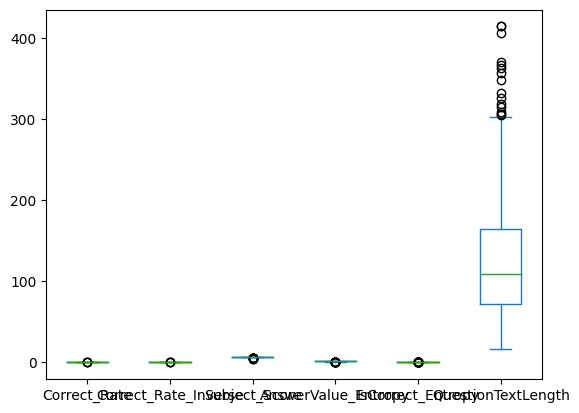

In [25]:
result_df.plot.box()


In [26]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaled = std_scaler.fit_transform(result_df)
scaled_df = pd.DataFrame(std_scaled, columns=['Correct_Rate', 'Correct_Rate_Inverse', 'Subject_Score',	'AnswerValue_Entropy',	'IsCorrect_Entropy',	'QuestionTextLength'])
scaled_df.head()

,Correct_Rate,Correct_Rate_Inverse,Subject_Score,AnswerValue_Entropy,IsCorrect_Entropy,QuestionTextLength
0,-0.405919,0.405919,0.116991,0.270462,0.646696,0.230130
1,0.411018,-0.411018,0.116991,-1.290954,0.592216,-1.117521
2,-0.777723,0.777723,-13.746451,0.943211,0.359719,-0.280559
3,1.926059,-1.926059,0.116991,-2.176383,-2.179250,-1.018221
4,-0.674342,0.674342,0.116991,0.907212,0.459543,0.003157


<Axes: >

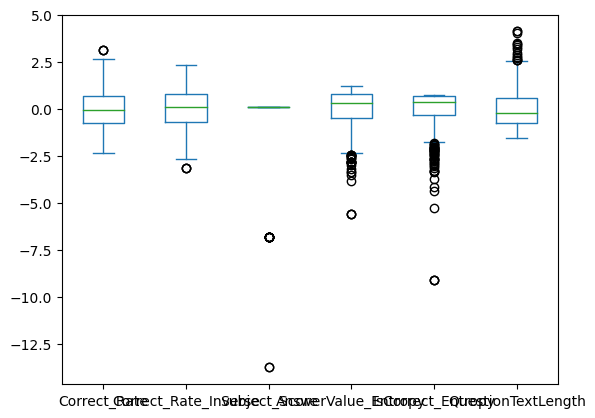

In [27]:
scaled_df.plot.box()

## Re-Select best subset

In [28]:
# Calculate the combination of all columns
combinations = []
column_combinations = []
num_columns = len(scaled_df.columns)

for r in range(1, num_columns+1):
    for cols in itertools.combinations(scaled_df.columns, r):
        combination_sum = scaled_df[list(cols)].sum(axis=1)
        combinations.append(combination_sum)
        column_combinations.append(list(cols))  # Save column name combinations

subset_df = pd.concat(combinations, axis=1)
subset_df.columns = ['Combination_{}'.format(i) for i in range(len(combinations))]

subset_rank_df = pd.DataFrame()
subset_rank_df = subset_df.rank(method='first', ascending=False).astype('int16')

subset_rank_df['QuestionId'] = subset_rank_df.index  # Add QuestionId Column
subset_rank_df = subset_rank_df[['QuestionId'] + subset_rank_df.columns[:-1].tolist()]  # Move the QuestionId column to the front

subset_templates = []
for i in range(len(combinations)):
  selected_columns = ['QuestionId', 'Combination_'+str(i)]
  subset_templates.append(subset_rank_df[selected_columns])

for template in subset_templates:
  template.columns = ['QuestionId', 'ranking']

In [29]:
# Evaluate Public
eval_pub_subset_result = []
for idx in range(len(subset_templates)):
  eval_pub_subset_result.append(evaluate(eval_validation, subset_templates[idx]))

score_dict = {}
for idx in range(len(subset_templates)):
  score, percent = getCompareDF(eval_validation, eval_pub_subset_result[idx])
  score_dict[str(column_combinations[idx])] = (score, percent)
  #print(f'{column_combinations[idx]}: {score}, {percent}')

sorted_scores = sorted(score_dict.items(), key=lambda x: x[1][0], reverse=True)[:10]
sorted_scores_rev = sorted(score_dict.items(), key=lambda x: x[1][0], reverse=False)[:10]

print('Best top 10')
for key, value in sorted_scores:
  print(f'{key}: {value}')

print('======')
print('Worst top 10')
for key, value in sorted_scores_rev:
  print(f'{key}: {value}')

Best top 10
['Subject_Score', 'AnswerValue_Entropy']: (22, 0.88)
['Correct_Rate_Inverse', 'Subject_Score', 'AnswerValue_Entropy']: (22, 0.88)
['Subject_Score', 'AnswerValue_Entropy', 'QuestionTextLength']: (22, 0.88)
['Correct_Rate', 'Correct_Rate_Inverse', 'Subject_Score', 'AnswerValue_Entropy']: (22, 0.88)
['Correct_Rate_Inverse', 'Subject_Score', 'AnswerValue_Entropy', 'IsCorrect_Entropy']: (22, 0.88)
['Correct_Rate_Inverse', 'Subject_Score', 'AnswerValue_Entropy', 'QuestionTextLength']: (22, 0.88)
['Correct_Rate', 'Correct_Rate_Inverse', 'Subject_Score', 'AnswerValue_Entropy', 'QuestionTextLength']: (22, 0.88)
['Correct_Rate_Inverse', 'Subject_Score', 'AnswerValue_Entropy', 'IsCorrect_Entropy', 'QuestionTextLength']: (22, 0.88)
['AnswerValue_Entropy']: (21, 0.84)
['Correct_Rate_Inverse', 'AnswerValue_Entropy']: (21, 0.84)
Worst top 10
['Correct_Rate']: (6, 0.24)
['Correct_Rate', 'Subject_Score']: (6, 0.24)
['Correct_Rate', 'IsCorrect_Entropy']: (7, 0.28)
['Correct_Rate', 'Subject_S

In [30]:
# Evaluate Private
eval_priv_subset_result = []
for idx in range(len(subset_templates)):
  eval_priv_subset_result.append(evaluate(eval_test, subset_templates[idx]))

score_dict = {}
for idx in range(len(subset_templates)):
  score, percent = getCompareDF(eval_test, eval_priv_subset_result[idx])
  score_dict[str(column_combinations[idx])] = (score, percent)
  #print(f'{column_combinations[idx]}: {score}, {percent}')

sorted_scores = sorted(score_dict.items(), key=lambda x: x[1][0], reverse=True)[:10]
sorted_scores_rev = sorted(score_dict.items(), key=lambda x: x[1][0], reverse=False)[:10]

print('Best top 10')
for key, value in sorted_scores:
  print(f'{key}: {value}')

print('======')
print('Worst top 10')
for key, value in sorted_scores_rev:
  print(f'{key}: {value}')

Best top 10
['Correct_Rate_Inverse', 'QuestionTextLength']: (18, 0.72)
['Correct_Rate_Inverse', 'Subject_Score', 'QuestionTextLength']: (18, 0.72)
['Correct_Rate_Inverse']: (17, 0.68)
['Correct_Rate_Inverse', 'Subject_Score']: (17, 0.68)
['Correct_Rate_Inverse', 'AnswerValue_Entropy', 'QuestionTextLength']: (17, 0.68)
['Correct_Rate_Inverse', 'IsCorrect_Entropy', 'QuestionTextLength']: (17, 0.68)
['Correct_Rate_Inverse', 'Subject_Score', 'AnswerValue_Entropy', 'QuestionTextLength']: (17, 0.68)
['Correct_Rate_Inverse', 'Subject_Score', 'IsCorrect_Entropy', 'QuestionTextLength']: (17, 0.68)
['Correct_Rate_Inverse', 'AnswerValue_Entropy', 'IsCorrect_Entropy', 'QuestionTextLength']: (17, 0.68)
['Correct_Rate_Inverse', 'Subject_Score', 'AnswerValue_Entropy', 'IsCorrect_Entropy', 'QuestionTextLength']: (17, 0.68)
Worst top 10
['Correct_Rate']: (8, 0.32)
['Correct_Rate', 'Subject_Score']: (8, 0.32)
['Correct_Rate', 'IsCorrect_Entropy']: (10, 0.4)
['Correct_Rate', 'Subject_Score', 'IsCorrect_E

## PCA

In [31]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scaled_df)

pca.components_.T
pca.components_[1] *= -1

df_pca = pca.transform(scaled_df)
print(df_pca)

loadings = pca.components_.T
loadings




[[ -0.81494127   0.23293888]
 [  1.20245408   0.58995168]
 [ -2.21461632 -11.70095998]
 ...
 [ -1.04829387   0.34366849]
 [ -0.75421173   0.40352323]
 [  0.84721218   0.27720888]]


array([[ 0.53270367,  0.01169801],
       [-0.53270367, -0.01169801],
       [ 0.06004273,  0.87170423],
       [-0.54241508,  0.09033928],
       [-0.30052082,  0.31034138],
       [-0.21052693, -0.36794713]])

(-0.6010567591620027,
 0.5914054147192408,
 -0.43425531514491317,
 0.9385959220894285)

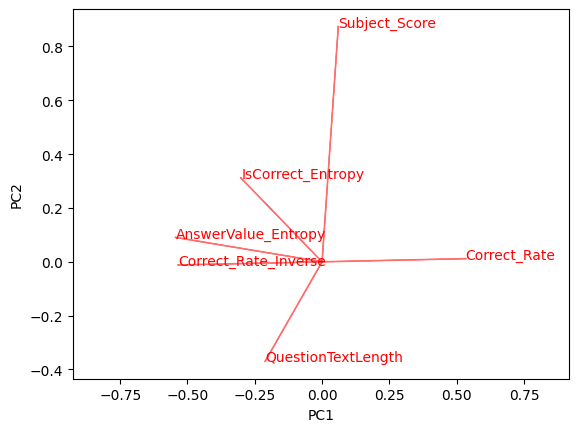

In [32]:
import matplotlib.pyplot as plt

# plot the loadings
for i, feature in enumerate(loadings):
    plt.arrow(0, 0, feature[0], feature[1], color='r', alpha=0.5)
    plt.text(feature[0], feature[1], f"{scaled_df.columns[i]}", color='r')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
